In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# SimpleRNN

In [2]:
# batch = 1, seqence = 3, hidden = 2, features = 4
model = nn.RNN(input_size=4, hidden_size=2, batch_first=True, bias=False)

In [3]:
print(model)

RNN(4, 2, bias=False, batch_first=True)


In [4]:
x_train = torch.tensor([  [ [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0] ] ], dtype=torch.float32 )
Wxh = np.array([[0, 0],
                [0, 0],
                [0, 1],
                [0, 0]], dtype=np.float32)
Whh = np.array([[1, 0],
                [0, 1]], dtype=np.float32)
model.weight_ih_l0.data = torch.from_numpy(Wxh.T)
model.weight_hh_l0.data = torch.from_numpy(Whh.T)

In [5]:
out, hidden = model(x_train)
out

tensor([[[0.0000, 0.0000],
         [0.0000, 0.7616],
         [0.0000, 0.6420]]], grad_fn=<TransposeBackward0>)

In [6]:
np.tanh(0.7615942)

0.6420150179019382

# Graph Vizualization

In [7]:
from graphviz import Digraph

In [8]:
class GradFnHook():
    def __init__(self, grad_fn):
        self.iter = 0
        self.grad_fn = grad_fn
    def __call__(self, inputs, outputs):
        self.iter += 1
        self.inputs = inputs
        self.outputs = outputs

In [9]:
def add_hooks(*output_tensors):
    def add_nodes(var):
        if var not in seen:
            
            bh = GradFnHook(var)
            var.register_hook(bh)
            
            hooks[var] = bh
            seen.add(var)
            
            #if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    add_nodes(u[0])

    # convert to nodes
    nodes = tuple(ot.grad_fn for ot in output_tensors)
    
    hooks = {}
    seen = set()
    
    for grad_fn in nodes:
        add_nodes(grad_fn)
        
    return hooks

In [10]:
def size_to_str(size):
    if len(size) == 0:
        return '(scalar)'
    return '(' + (', ').join(['%d' % v for v in size]) + ')'

In [11]:
def var_to_str(var):
    def rchop(string, endings):
        for ending in endings:
            if string.endswith(ending):
                return string[:-len(ending)]
        return string
    return rchop(type(var).__name__, ['Backward', 'Backward0', 'Backward1', 'Backward2', 'Backward3'])

In [12]:
class DummyGradFn():
    def __init__(self, tensor):
        self.variable = tensor
        self.next_functions = [[tensor.grad_fn, 0]]

In [13]:
def make_dot(outputs, inputs=None, params=None, hooks=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """

    def add_nodes(var):
        if var not in seen:
            if hasattr(var, 'variable'):
                tensor = var.variable
                
                if id(tensor) in output_map:
                    name = output_map[id(tensor)]
                    color = 'darkolivegreen1'
                elif id(tensor) in param_map:
                    name = param_map[id(tensor)]
                    color = 'orange'
                elif id(tensor) in input_map:
                    name = input_map[id(tensor)]
                    color = 'lightblue'
                else:
                    name = ''
                    color = 'lightgray'
            
                node_name = str.format('{}\n{}', name, size_to_str(tensor.size()))
                dot.node(str(id(var)), node_name, fillcolor=color, style='filled', shape='box')
            
            else:
                
                if hooks is not None and var in hooks:
                    output_tensors = hooks[var].outputs
                    node_name = var_to_str(var)
                    for tensor in output_tensors:
                        node_name += '\n' + size_to_str(tensor.size())
                    
                else:
                    node_name = var_to_str(var)
                
                dot.node(str(id(var)), node_name, fillcolor='lightgray')
            
            seen.add(var)
            
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        label = None
#                         if hooks is not None and var in hooks and u[0] in hooks:
#                             inp_tup = hooks[var].inputs  # tensor
#                             out_tup = hooks[u[0]].outputs
#                             inters = set(inp_tup).intersection(set(out_tup))
#                             if len(inters) == 1:  # if multiple paths through graph then this will fail
#                                 tensor = inters.pop()
#                                 label = size_to_str(tensor.size())
                        
                        dot.edge(str(id(u[0])), str(id(var)), label=label)
                        add_nodes(u[0])

    assert all(isinstance(o, torch.Tensor) for o in outputs.values())
    output_map = {id(tensor): string for string, tensor in outputs.items()}
        
    if inputs is not None:
        assert all(isinstance(i, torch.Tensor) for i in inputs.values())
        input_map = {id(tensor): string for string, tensor in inputs.items()}
    else:
        input_map = {}
        
    if params is not None:
        assert all(isinstance(p, torch.Tensor) for p in params.values())
        param_map = {id(tensor): string for string, tensor in params.items()}
    else:
        param_map = {}

    node_attr = dict(style='rounded,filled', shape='box', align='top', fontsize='12', ranksep='0.1', height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="10,1000"))

    seen = set()

    output_nodes = [DummyGradFn(tensor) for _, tensor in outputs.items()]
            
            
    for grad_fn in output_nodes:
        add_nodes(grad_fn)


    return dot

# Visualize RNN

In [14]:
# batch = 1, seqence = 3, hidden = 2, features = 4
model = nn.RNN(input_size=4, hidden_size=2, batch_first=True, bias=False)

In [15]:
x_train = torch.tensor([  [ [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0] ] ],
                       dtype=torch.float32, requires_grad=True )
hid = None

out, hid = model(x_train, hid)
# hid = hid.detach()               # next minibatch, keep hidden state
# out, hid = model(x_train, hid)

#hooks = add_hooks(out)
out.backward(torch.ones_like(out))
#hid.backward(torch.ones_like(hid))

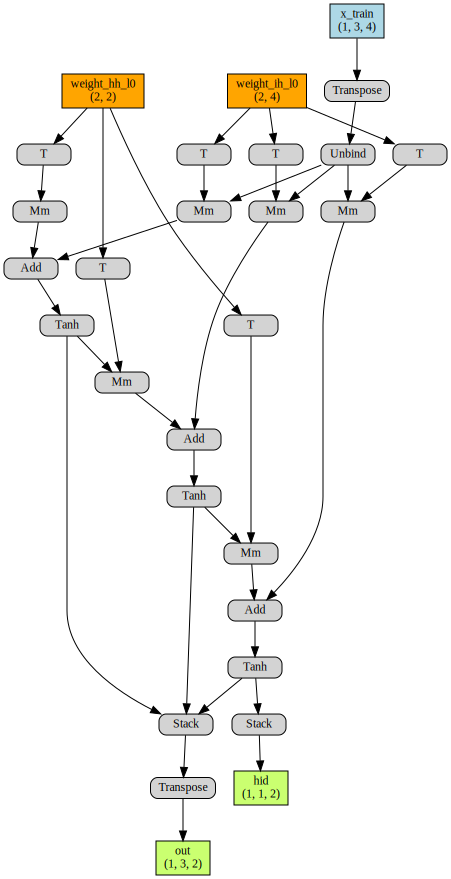

In [16]:
make_dot(outputs={'out': out, 'hid':hid},
         inputs={'x_train': x_train},
         params=dict(model.named_parameters()),
         hooks=None)